# Neural Network for Regression (predict next character in a word) exercise

*Complete and hand in this completed worksheet (including its outputs and any supporting code outside of the worksheet) with your assignment submission. For more details see the [HW page](http://kovan.ceng.metu.edu.tr/~sinan/DL/index.html) on the course website.*

Having gained some experience with neural networks, let us train a network that predicts the next character given a set of characters in a text.

All of your work for this exercise will be done in this notebook.

In [1]:
import random
import numpy as np
from metu.data_utils import load_nextchar_dataset, plain_text_file_to_dataset
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# for auto-reloading extenrnal modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

def rel_error(x, y):
  """ returns relative error """
  return np.max(np.abs(x - y) / (np.maximum(1e-8, np.abs(x) + np.abs(y))))

In [2]:
# Create a small net and some toy data to check your implementations.
# Note that we set the random seed for repeatable experiments.
from cs231n.classifiers.neural_net_for_regression import TwoLayerNet

input_size = 4
hidden_size = 10
num_classes = 3
num_inputs = 5

def init_toy_model():
  np.random.seed(0)
  return TwoLayerNet(input_size, hidden_size, num_classes, std=1e-1)

def init_toy_data():
  np.random.seed(1)
  X = 10 * np.random.randn(num_inputs, input_size)
  y = np.array([[0, 1, 2], [1, 2, 3], [2, 3, 4], [2, 1, 4], [2, 1, 4]])
  return X, y

net = init_toy_model()
X, y = init_toy_data()

# Forward pass: compute scores
Open the file `cs231n/classifiers/neural_net_for_regression.py` and look at the method `TwoLayerNet.loss`. This function is very similar to the loss functions you have written for the previous exercises: It takes the data and weights and computes the *regression* scores, the squared error loss, and the gradients on the parameters. 

To be more specific, you will implement the following loss function:

$$\frac{1}{2}\sum_i (o_i - y_i)^2 + \frac{1}{2}\lambda\sum_j w_j^2,$$

where $i$ runs through the samples in the batch; $o_i$ is the prediction of the network for the $i^{th}$ sample, and $y_i$ is the correct character; $\lambda$ is the weight of the regularization term.

The first layer uses ReLU as the activation function. The output layer does not use any activation functions.

Implement the first part of the forward pass which uses the weights and biases to compute the scores for all inputs.

In [3]:
scores = net.loss(X)
print 'Your scores:'
print scores
print
print 'correct scores:'
correct_scores = np.asarray([
  [-0.81233741, -1.27654624, -0.70335995],
  [-0.17129677, -1.18803311, -0.47310444],
  [-0.51590475, -1.01354314, -0.8504215 ],
  [-0.15419291, -0.48629638, -0.52901952],
  [-0.00618733, -0.12435261, -0.15226949]])
print correct_scores
print

# The difference should be very small. We get < 1e-7
print 'Difference between your scores and correct scores:'
print np.sum(np.abs(scores - correct_scores))

Your scores:
[[-0.81233741 -1.27654624 -0.70335995]
 [-0.17129677 -1.18803311 -0.47310444]
 [-0.51590475 -1.01354314 -0.8504215 ]
 [-0.15419291 -0.48629638 -0.52901952]
 [-0.00618733 -0.12435261 -0.15226949]]

correct scores:
[[-0.81233741 -1.27654624 -0.70335995]
 [-0.17129677 -1.18803311 -0.47310444]
 [-0.51590475 -1.01354314 -0.8504215 ]
 [-0.15419291 -0.48629638 -0.52901952]
 [-0.00618733 -0.12435261 -0.15226949]]

Difference between your scores and correct scores:
3.68027209324e-08


# Forward pass: compute loss
In the same function, implement the second part that computes the data and regularizaion loss.

In [4]:
loss, _ = net.loss(X, y, reg=0.1)
correct_loss = 66.3406756909

# should be very small, we get < 1e-10
print 'Difference between your loss and correct loss:'
print np.sum(np.abs(loss - correct_loss))

Difference between your loss and correct loss:
2.54800625044e-11


# Backward pass
Implement the rest of the function. This will compute the gradient of the loss with respect to the variables `W1`, `b1`, `W2`, and `b2`. Now that you (hopefully!) have a correctly implemented forward pass, you can debug your backward pass using a numeric gradient check:

In [5]:
from cs231n.gradient_check import eval_numerical_gradient

# Use numeric gradient checking to check your implementation of the backward pass.
# If your implementation is correct, the difference between the numeric and
# analytic gradients should be less than 1e-8 for each of W1, W2, b1, and b2.

loss, grads = net.loss(X, y, reg=0.1)

# these should all be less than 1e-8 or so
for param_name in grads:
  #this grad check is faulty, it takes parameter W but never uses it
  f = lambda W: net.loss(X, y, reg=0.1)[0]
  param_grad_num = eval_numerical_gradient(f, net.params[param_name])
  print '%s max relative error: %e' % (param_name, rel_error(param_grad_num, grads[param_name]))

W1 max relative error: 5.463838e-04
W2 max relative error: 3.755046e-04
b2 max relative error: 1.443387e-06
b1 max relative error: 2.188996e-07


# Load a dataset for training a simple regression network

In [38]:
# Load the TEXT data
# If your memory turns out to be sufficient, try the following:
#def get_nextchar_data(training_ratio=0.6, val_ratio=0.1):
def get_nextchar_data(training_ratio=0.1, test_ratio=0.06, val_ratio=0.01):
  # Load the nextchar training data 
  X, y = load_nextchar_dataset(nextchar_datafile)
  # Subsample the data
  length=len(y)
  num_training=int(length*training_ratio)
  num_val = int(length*val_ratio)
  num_test = min((length-num_training-num_val), int(length*test_ratio))
  mask = range(num_training-1)
  X_train = X[mask]
  y_train = y[mask]
  mask = range(num_training, num_training+num_test)
  X_test = X[mask]
  y_test = y[mask]
  mask = range(num_training+num_test, num_training+num_test+num_val)
  X_val = X[mask]
  y_val = y[mask]

  return X_train, y_train, X_val, y_val, X_test, y_test

nextchar_datafile = 'metu/dataset/nextchar_data.pkl'
input_size = 5 # Size of the input of the network
#plain_text_file_to_dataset("metu/dataset/ince_memed_1.txt", nextchar_datafile, input_size)
plain_text_file_to_dataset("metu/dataset/shakespeare.txt", nextchar_datafile, input_size)
X_train, y_train, X_val, y_val, X_test, y_test = get_nextchar_data()
print "Number of instances in the training set: ", len(X_train)
print "Number of instances in the validation set: ", len(X_val)
print "Number of instances in the testing set: ", len(X_test)

Converting plain text file to trainable dataset (as pickle file)
Processing file metu/dataset/shakespeare.txt as input
input_size parameter (i.e. num of neurons) will be 5
Writing data and labels to file metu/dataset/nextchar_data.pkl
Loading X and Y from pickle file metu/dataset/nextchar_data.pkl
Number of instances in the training set:  37647
Number of instances in the validation set:  3764
Number of instances in the testing set:  22589


In [39]:
# We have loaded the dataset. That wasn't difficult, was it? :)
# Let's look at a few samples
#
from metu.data_utils import int_list_to_string, int_to_charstr

print "Input - Next char to be predicted"
for i in range(1,10):
    print int_list_to_string(X_train[i]) + " - " + int_list_to_string(y_train[i])

Input - Next char to be predicted
HE SO - N
E SON - N
 SONN - E
SONNE - T
ONNET - S
by Wi - l
y Wil - l
 Will - i
Willi - a


# Now train our network on the nextchar dataset

In [69]:
# Now, let's train a neural network

input_size = input_size
hidden_size = 5000
num_classes = 1
net = TwoLayerNet(input_size, hidden_size, num_classes)

# Train the network
stats = net.train(X_train, y_train, X_val, y_val,
            num_iters=4000, batch_size=32*8,
            learning_rate=6e-7, learning_rate_decay=0.95,
            reg=5, verbose=True)

# Predict on the validation set
val_err = np.sum(np.square(net.predict(X_val) - y_val), axis=1).mean()
print 'Validation error: ', val_err

iteration 0 / 4000: loss 1191456.180242
iteration 100 / 4000: loss 1081576.053361
iteration 200 / 4000: loss 1055188.250408
iteration 300 / 4000: loss 1794711.194733
iteration 400 / 4000: loss 1103742.701109
iteration 500 / 4000: loss 1078587.510633
iteration 600 / 4000: loss 967011.683003
iteration 700 / 4000: loss 928023.555608
iteration 800 / 4000: loss 150536.350821
iteration 900 / 4000: loss 979725.347889
iteration 1000 / 4000: loss 917220.501422
iteration 1100 / 4000: loss 879715.589520
iteration 1200 / 4000: loss 640055.798165
iteration 1300 / 4000: loss 410950.018063
iteration 1400 / 4000: loss 244154.828708
iteration 1500 / 4000: loss 174068.554566
iteration 1600 / 4000: loss 146760.114685
iteration 1700 / 4000: loss 201318.065499
iteration 1800 / 4000: loss 234944.710857
iteration 1900 / 4000: loss 248821.949516
iteration 2000 / 4000: loss 274896.385148
iteration 2100 / 4000: loss 180503.277616
iteration 2200 / 4000: loss 140573.472614
iteration 2300 / 4000: loss 125186.73253

# Debug the training
I have managed to get a loss below 10,000 and a validation error of about 1100 on the validation set (by playing around the parameters a little bit). However, this isn't very good.

One strategy for getting insight into what's wrong is to plot the loss function and the accuracies on the training and validation sets during optimization.

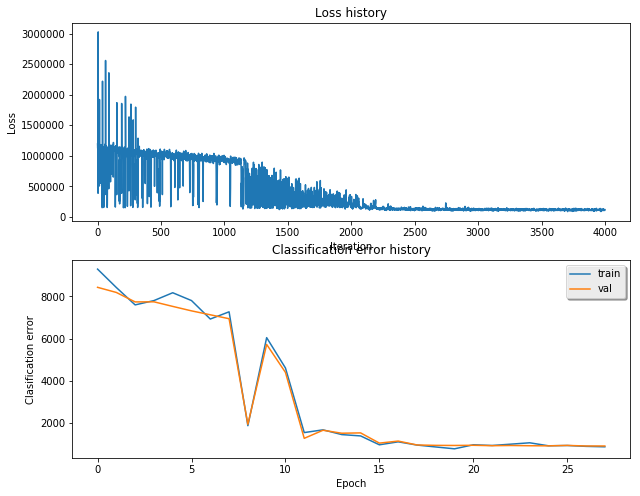

In [70]:
# Plot the loss function and train / validation errors
plt.subplot(2, 1, 1)
plt.plot(stats['loss_history'])
plt.title('Loss history')
plt.xlabel('Iteration')
plt.ylabel('Loss')

plt.subplot(2, 1, 2)
train = plt.plot(stats['train_err_history'], label='train')
val = plt.plot(stats['val_err_history'], label='val')
plt.legend(loc='upper right', shadow=True)
plt.title('Classification error history')
plt.xlabel('Epoch')
plt.ylabel('Clasification error')
plt.show()

In [71]:
# Show some sample outputs:

print "Input - predicted char - true char"
for i in range(0,100):
    print int_list_to_string(X_val[i]) + " - "  \
        + int_list_to_string([int(x) for x in net.predict(X_val[i])]) \
        + " - " + int_list_to_string(y_val[i]), net.predict(X_val[i]), y_val[i]

Input - predicted char - true char
d mar - U - k [ 85.40055154] [107]
 mark - H -   [ 72.76514826] [32]
mark  - m - t [ 109.35998782] [116]
ark t - o - h [ 111.48016155] [104]
rk th - Y - e [ 89.63968721] [101]
k the - V -   [ 86.02565754] [32]
 the  - [ - m [ 91.0752276] [109]
the m - k - a [ 107.2185111] [97]
he ma - S - n [ 83.40721927] [110]
e man - T - n [ 84.5923037] [110]
 mann - H - e [ 72.92954276] [101]
manne - P - r [ 80.44496459] [114]
anner - T -   [ 84.04548832] [32]
nner  - l - o [ 108.13145719] [111]
ner o - h - f [ 104.99253561] [102]
er of - X -   [ 88.65409179] [32]
r of  - a - h [ 97.71976589] [104]
 of h - \ - i [ 92.95936818] [105]
of hi - ] - s [ 93.96559114] [115]
f his - U -   [ 85.15391553] [32]
 his  - b - t [ 98.67466595] [116]
his t - m - e [ 109.39072055] [101]
is te - V - a [ 86.48470392] [97]
s tea - U - c [ 85.2690927] [99]
 teac - E - h [ 69.71532766] [104]
teach - O - i [ 79.35100975] [105]
eachi - L - n [ 76.68521088] [110]
achin - O - g [ 79.0685086

In [72]:
test_err = np.sum(np.square(net.predict(X_test) - y_test), axis=1).mean()
print 'Test error: ', test_err

Test error:  882.148585229


In [73]:
# Show some sample outputs:
print "Input - predicted char - true char"
for i in range(0,100):
    print int_list_to_string(X_test[i]) + " - "  \
        + int_list_to_string([int(x) for x in net.predict(X_test[i])]) \
        + " - " + int_list_to_string(y_test[i]), net.predict(X_test[i]), y_test[i]

Input - predicted char - true char
icio, - V -   [ 86.64584691] [32]
cio,  - P - t [ 80.85054059] [116]
io, t -  - o [ 127.46800472] [111]
o, to - Y -   [ 89.47092366] [32]
, to  - _ - y [ 95.55228754] [121]
 to y - l - o [ 108.0216727] [111]
to yo - _ - u [ 95.42607261] [117]
o you - \ - . [ 92.14127123] [46]
    G - E - o [ 69.16199273] [111]
   Go - ^ - o [ 94.78215684] [111]
  Goo - G - d [ 71.1739196] [100]
 Good - M -   [ 77.90440575] [32]
Good  - c - m [ 99.50546522] [109]
ood m - k - a [ 107.62165208] [97]
od ma - T - s [ 84.12114393] [115]
d mas - U - t [ 85.62294199] [116]
 mast - L - e [ 76.53121197] [101]
maste - R - r [ 82.72998943] [114]
aster - S - , [ 83.11836421] [44]
ster, - \ -   [ 92.65632527] [32]
ter,  - U - t [ 85.3790217] [116]
er, t -  - a [ 127.31865558] [97]
r, ta - L - k [ 76.0484107] [107]
, tak - R - e [ 82.72760114] [101]
 take - F -   [ 70.12091901] [32]
take  - f - i [ 102.91304778] [105]
ake i - e - t [ 101.37638179] [116]
ke it - g -   [ 103.8607644